In [81]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
import numpy
import PIL
from PIL import Image
np.random.seed(1337)  # for reproducibility

import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.optimizers import RMSprop
from keras import backend as K
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate


def conc_shape(shapes):
    shape1, shape2 = shapes
    return(shape1[0], 256)

def conc_output(vects):
    x, y = vects
    conc = concatenate([x,y])
    return conc
    

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def euclidean_distance(x, y):
     return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))



#def softmax(z): return np.exp(z)/((np.exp(z)).sum())

def contrastive_loss1(p ,q, y_true):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    y_pred = euclidean_distance(p, q)
    #print(y_pred)
    #y_pred = tf.reshape(y_pred, [p.shape[0],1])
    margin = 1
    
    return (y_true *K.square(y_pred) +(1 - y_true) *K.square(K.maximum(margin - y_pred, 0)))

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def kl_divergence_loss(p, q):
    '''Kullback Leiber Divergence loss'''
    
    p = K.clip(p, K.epsilon(), 1)
    q= K.clip(q, K.epsilon(), 1)
    
    return p*K.log(p/q)

def total_loss1(Y_true, Y_pred):
    p = Y_pred[:,0:128]
    q = Y_pred[:,128:256]
    y_true = Y_true[:,0]
    isSame = Y_true[:,1]
    
    return total_loss(y_true, isSame, p, q)
    
def total_loss(y_true, isSame, p, q):
    y_pred = euclidean_distance(p, q)
    
    
    margin = 1
    p = K.clip(p, K.epsilon(), 1)
    q= K.clip(q, K.epsilon(), 1)
    return K.mean(isSame*(contrastive_loss(y_true, y_pred)) + (1-isSame)*(kl_divergence_loss(p,q)))
    
    #return K.mean(isSame*(y_true *K.square(y_pred) +(1 - y_true) *K.square(K.maximum(margin - y_pred, 0))) + (1-isSame)*(p*K.log(p/q)))

def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network():
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    seq.add(Conv2D(30, (5, 5), input_shape=(28, 28,1), activation='relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))
    seq.add(Dropout(0.2))
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(128, activation='relu'))
    return seq


def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return labels[predictions.ravel() < 0.5].mean()



In [91]:
nb_epoch=5

In [93]:
print(tr_final[0:12800,].shape)

(12800, 2)


In [94]:
# train
rms = RMSprop()
model.compile(loss=total_loss1, optimizer=rms)
model.fit([tr_pairs1[0:12800,0], tr_pairs1[0:12800, 1]], tr_final[0:12800,],
          #validation_data=([te_pairs1[:,0], te_pairs1[:, 1]], te_final),
          batch_size=128,
          nb_epoch=nb_epoch)



/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Epoch 1/5
12800/12800 [==============================] - 9s 739us/step - loss: 0.2531
Epoch 2/5
12800/12800 [==============================] - 9s 728us/step - loss: 0.2527
Epoch 3/5
12800/12800 [==============================] - 9s 732us/step - loss: 0.2527
Epoch 4/5
12800/12800 [==============================] - 9s 735us/step - loss: 0.2526
Epoch 5/5
12800/12800 [==============================] - 10s 754us/step - loss: 0.2525


In [89]:
print(te_pairs1[:,1].shape)
print(te_pairs1[:,0].shape)
print(te_final.shape)

(17820, 28, 28, 1)
(17820, 28, 28, 1)
(17820, 2)


In [19]:
seed=7
numpy.random.seed(seed)

In [20]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

X_test = X_test.astype('float32')
X_train = X_train.astype('float32')

In [21]:
#X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
#X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [22]:
X_train=X_train/255
X_test=X_test/255

In [23]:
print(y_train)

[5 0 4 ... 5 6 8]


In [24]:
input_dim = 784
nb_epoch = 20

In [25]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(10)]
tr_pairs, tr_y = create_pairs(X_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(10)]
te_pairs, te_y = create_pairs(X_test, digit_indices)

In [26]:
base_network = create_base_network()

In [27]:

X_temp=X_train.reshape(-1,28,28,1)
input_dim = X_temp.shape[1:]
print(input_dim)

(28, 28, 1)


In [28]:

# network definition
base_network = create_base_network()

input_a = Input(shape=input_dim)
input_b = Input(shape=input_dim)

#input_a=K.reshape(input_a,(28,28,1))
#input_b=K.reshape(input_b,(28,28,1))
# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
print(input_b.shape)

(?, 28, 28, 1)


In [48]:
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(conc_output, output_shape=conc_shape)([processed_a, processed_b])

model = Model(input=[input_a, input_b], output=distance)

/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("la..., inputs=[<tf.Tenso...)`
  


In [49]:
processed_a.shape

TensorShape([Dimension(None), Dimension(128)])

In [50]:
distance.shape

TensorShape([Dimension(None), Dimension(256)])

In [118]:
test_model = Model(input = input_a, output = processed_a)

/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("se..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [113]:
test_model1 = Model(input = input_b, output = processed_b)

/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("se..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [52]:
tr_pairs1=tr_pairs.reshape(-1,2,28,28,1)
te_pairs1=te_pairs.reshape(-1,2,28,28,1)

print(tr_pairs1.shape)
print(te_pairs1.shape)

(108400, 2, 28, 28, 1)
(17820, 2, 28, 28, 1)


In [53]:
print(tr_pairs1[:,0].shape)

(108400, 28, 28, 1)


In [86]:
print(108400/128)
print(17820/128)

846.875
139.21875


In [54]:
print(tr_pairs[:, 1])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [55]:
print(tr_y)

[1 0 1 ... 0 1 0]


In [57]:
tr_same = []
for i in range(tr_y.shape[0]):
    tr_same += [1]
te_same = []
for i in range(te_y.shape[0]):
    te_same += [1]
tr_same = np.array(tr_same)
te_same = np.array(te_same)
print(tr_same.shape)
print(te_same.shape)
print(tr_y.shape)


(108400,)
(17820,)
(108400,)


In [58]:
print(tr_same)

[1 1 1 ... 1 1 1]


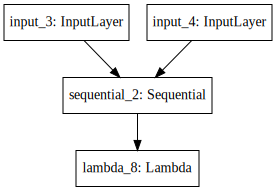

In [59]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

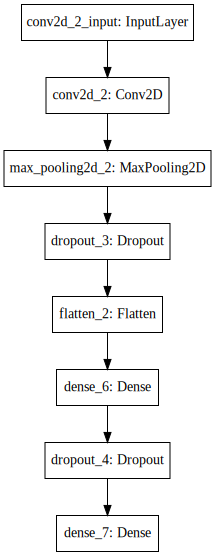

In [60]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(base_network).create(prog='dot', format='svg'))

In [96]:
nb_epoch=10

In [62]:
print(tr_same.shape)
print(tr_y.shape)
print(tr_same)

(108400,)
(108400,)
[1 1 1 ... 1 1 1]


In [69]:
tr_y = tr_y.reshape(-1,1)
tr_same = tr_same.reshape(-1,1)

In [63]:
model.output

<tf.Tensor 'lambda_8/concatenate_15/concat:0' shape=(?, 256) dtype=float32>

In [70]:
tr_final = np.concatenate((tr_y, tr_same), axis=1)
print(tr_final.shape)

(108400, 2)


In [71]:
te_y = te_y.reshape(-1,1)
te_same = te_same.reshape(-1,1)
te_final = np.concatenate((te_y, te_same), axis=1)
print(te_final.shape)

(17820, 2)


In [ ]:
17792, 108288

In [95]:
print(tr_final[0:17792].shape)

(17792, 2)


In [126]:
print(tr_final.shape)

(108400, 2)


In [98]:
# train
rms = RMSprop()
model.compile(loss=total_loss1, optimizer=rms)
model.fit([tr_pairs1[0:108288,0], tr_pairs1[0:108288, 1]], tr_final[0:108288],
          validation_data=([te_pairs1[0:17792,0], te_pairs1[0:17792, 1]], tr_final[0:17792]),
          batch_size=128,
          nb_epoch=nb_epoch)



/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 108288 samples, validate on 17792 samples
Epoch 1/10
108288/108288 [==============================] - 83s 764us/step - loss: 0.2527 - val_loss: 0.2619
Epoch 2/10
108288/108288 [==============================] - 83s 767us/step - loss: 0.2524 - val_loss: 0.2630
Epoch 3/10
108288/108288 [==============================] - 83s 769us/step - loss: 0.2523 - val_loss: 0.2613
Epoch 4/10
108288/108288 [==============================] - 84s 774us/step - loss: 0.2522 - val_loss: 0.2594
Epoch 5/10
108288/108288 [==============================] - 76s 705us/step - loss: 0.2522 - val_loss: 0.2564
Epoch 6/10
108288/108288 [==============================] - 76s 705us/step - loss: 0.2522 - val_loss: 0.2580
Epoch 7/10
108288/108288 [==============================] - 81s 745us/step - loss: 0.2520 - val_loss: 0.2577
Epoch 8/10
108288/108288 [==============================] - 83s 766us/step - loss: 0.2519 - val_loss: 0.2537
Epoch 9/10
108288/108288 [==============================] - 83s 770us/step - 

In [99]:
# compute final accuracy on training and test sets
pred = model.predict([tr_pairs1[:,0], tr_pairs1[:, 1]])
tr_acc = compute_accuracy(pred, tr_y)
pred = model.predict([te_pairs1[:,0], te_pairs1[:, 1]])
te_acc = compute_accuracy(pred, te_y)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 108400 but corresponding boolean dimension is 27750400

In [100]:
y_test1=[]
for i in range(0,10):
    for j in range(1,201):
        y_test1.append(i)
y_test1=np.array(y_test1)
print(y_test1.size)
print(y_test1)

2000
[0 0 0 ... 9 9 9]


In [101]:
X_test1=[]
for i in range(0,10):
    for j in range(1,201):
        img = PIL.Image.open("/home/aniruddha/Documents/USPSdataset/%d/%d.jpg" %(i,j)).convert("L")
        arr = np.array(img)
        # ravel to convert 28x28 to 784 1D array
        arr=arr.ravel()
        X_test1.append(arr)
X_test1=np.array(X_test1)
print(X_test1.shape)
print(X_test.shape)

(2000, 784)
(10000, 784)


In [102]:
X_test1 = X_test1.reshape(2000, 784)
X_test1 = X_test1.astype('float32')
X_test1 /= 255
print(X_test.shape)


digit_indices = [np.where(y_test1 == i)[0] for i in range(10)]
te_pairs, te_y = create_pairs(X_test1, digit_indices)

(10000, 784)


In [103]:
te_pairs2=te_pairs.reshape(-1,2,28,28,1)

print(te_pairs2.shape)

(3980, 2, 28, 28, 1)


In [104]:
pred = model.predict([te_pairs2[:, 0], te_pairs2[:, 1]])
te_acc = compute_accuracy(pred, te_y)

# compute accuracy on new USPS dataset to check degree of transfer learning
# model only trained on MNIST dataset
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3980 but corresponding boolean dimension is 1018880

In [105]:
%matplotlib inline

from time import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import manifold, datasets, decomposition, ensemble, discriminant_analysis, random_projection

In [106]:
def plot_embedding(mu, Y, title=None):
    num_class = 1000 # data points per class
#     x_min, x_max = np.min(mu, 0), np.max(mu, 0)
#     mu = (mu - x_min) / (x_max - x_min)
    
#     classes = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 15, 16, 18, 19, 
#                20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 39, 40, 42, 43, 44, 45, 46, 48, 49]
    
    classes = [0,1,2,3,4,5,6,7,8,9]
    data = [[] for i in classes]
    for i, y in enumerate(Y):
        data[classes.index(y)].append(np.array(mu[i]))
            
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'olive', 'orange', 'mediumpurple']
    l = [i for i in range(10)]
    alphas = 0.3 * np.ones(10)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    font_size = 13
    for i in range(10):
        temp = np.array(data[i])
        l[i] = plt.scatter(temp[:num_class, 0], temp[:num_class, 1], s = 5, c = colors[i], edgecolors = 'face', alpha=alphas[i])
    leg = plt.legend((l[0],l[1],l[2],l[3],l[4],l[5],l[6],l[7],l[8],l[9]), 
               ('0','1','2','3','4','5','6','7','8','9'), loc='center left', bbox_to_anchor=(1, 0.5), fontsize=font_size)
    leg.get_frame().set_linewidth(0.0)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)

In [122]:
X_test1=X_test1.reshape(-1,28,28,1)

In [110]:
print(X_test.shape)
X_test = X_test.reshape(-1,28,28,1)

(10000, 784)


In [123]:
processed=test_model.predict(X_test1)

Computing t-SNE embedding


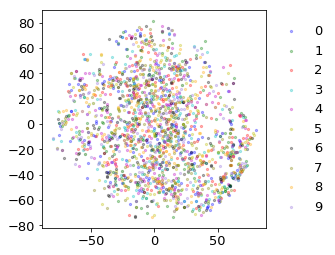

In [112]:
print("Computing t-SNE embedding")
tsne_pred = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne_pred = tsne_pred.fit_transform(processed)

plot_embedding(X_tsne_pred, y_test1,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

Computing t-SNE embedding


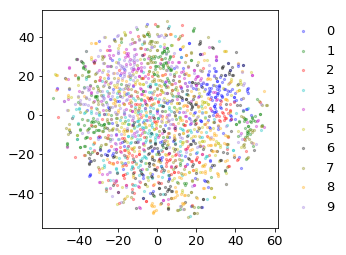

In [125]:
print("Computing t-SNE embedding")
tsne_pred = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne_pred = tsne_pred.fit_transform(processed)

plot_embedding(X_tsne_pred, y_test1,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

In [49]:
X_train11=X_train.reshape(-1,28,28,1)
X_test11=X_test.reshape(-1,28,28,1)

In [50]:
processed_train=test_model.predict(X_train11)
processed_test=test_model.predict(X_test11)

In [51]:
num_pixels = 128
processed_train = processed_train.reshape(processed_train.shape[0], num_pixels).astype('float32')
processed_test = processed_test.reshape(processed_test.shape[0], num_pixels).astype('float32')

print(num_pixels)
print(processed_train.shape)
print(processed_test.shape)

128
(60000, 128)
(10000, 128)


In [52]:
from keras.utils import np_utils
y_train1 = np_utils.to_categorical(y_train)
y_test1 = np_utils.to_categorical(y_test)
num_classes = 10

In [53]:
# define baseline model
def baseline_model1():
	# create model
	model = Sequential()
	model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
	model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [54]:

# build the model
model1 = baseline_model1()
# Fit the model
model1.fit(processed_train, y_train1, validation_data=(processed_test, y_test1), epochs=10, batch_size=200, verbose=1)
# Final evaluation of the model
scores_test = model1.evaluate(processed_test, y_test1, verbose=1)
scores_train = model1.evaluate(processed_train, y_train1, verbose=1)


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 15us/step - loss: 0.6548 - acc: 0.9789 - val_loss: 0.0565 - val_acc: 0.9901
Epoch 2/10
60000/60000 [==============================] - 1s 12us/step - loss: 0.0228 - acc: 0.9968 - val_loss: 0.0400 - val_acc: 0.9900
Epoch 3/10
60000/60000 [==============================] - 1s 12us/step - loss: 0.0160 - acc: 0.9968 - val_loss: 0.0392 - val_acc: 0.9904
Epoch 4/10
60000/60000 [==============================] - 1s 14us/step - loss: 0.0148 - acc: 0.9968 - val_loss: 0.0391 - val_acc: 0.9903
Epoch 5/10
60000/60000 [==============================] - 1s 17us/step - loss: 0.0143 - acc: 0.9968 - val_loss: 0.0399 - val_acc: 0.9906
Epoch 6/10
60000/60000 [==============================] - 1s 15us/step - loss: 0.0141 - acc: 0.9968 - val_loss: 0.0398 - val_acc: 0.9905
Epoch 7/10
60000/60000 [==============================] - 1s 18us/step - loss: 0.0140 - acc: 0.9968 - val_loss: 0.0400 - val_acc

In [55]:
#scores_train=scores_train/1.0
#scores_test=scores_test/1.0
print('* Accuracy on training set: %0.2f%%' % (100 * scores_train[1]))
print('* Accuracy on test set: %0.2f%%' % (100 * scores_test[1]))

* Accuracy on training set: 99.69%
* Accuracy on test set: 99.06%


In [56]:
y_test2=[]
for i in range(0,10):
    for j in range(1,201):
        y_test2.append(i)
y_test2=np.array(y_test2)
print(y_test2.size)

2000


In [57]:
from keras.utils import np_utils
y_test2 = np_utils.to_categorical(y_test2)
num_classes = 10

In [58]:
scores_test_USPS=model1.evaluate(processed, y_test2, verbose=1)
print('* Accuracy on test USPS set: %0.2f%%' % (100 * scores_test_USPS[1]))

2000/2000 [==============================] - 0s 27us/step
* Accuracy on test USPS set: 62.95%


In [1]:
import keras

input1 = keras.layers.Input(shape=(16,))
x1 = keras.layers.Dense(8, activation='relu')(input1)
input2 = keras.layers.Input(shape=(32,))
x2 = keras.layers.Dense(8, activation='relu')(input2)
added = keras.layers.Add()([x1, x2])  # equivalent to added = keras.layers.add([x1, x2])

out = keras.layers.Dense(4)(added)
model = keras.models.Model(inputs=[input1, input2], outputs=out)

/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
print(added.shape)
print(x1.shape)

(?, 8)
(?, 8)


In [15]:
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
conc = concatenate([x1,x2])
print(conc.shape)
a = conc[:,0:8]
b = conc[:,8:16]
print(a.shape)
print(b.shape)

(?, 16)
(?, 8)
(?, 8)


In [1]:
import numpy as np
import tensorflow as tf

def tf_cov(x):
    mean_x = tf.reduce_mean(x, axis=0, keep_dims=True)
    mx = tf.matmul(tf.transpose(mean_x), mean_x)
    vx = tf.matmul(tf.transpose(x), x)/tf.cast(tf.shape(x)[0], tf.float32)
    cov_xx = vx - mx
    loss = tf.reduce_mean(tf.matmul(cov_xx,cov_xx))
    return cov_xx

data = np.array([[1., 4, 2], [5, 6, 24], [15, 1, 5], [7,3,8], [9,4,7]])

with tf.Session() as sess:
    print(sess.run(tf_cov(tf.constant(data, dtype=tf.float32))))


## validating with numpy solution
pc = np.cov(data.T, bias=True)
print(pc)

/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[[21.439995  -5.4399986 -4.880001 ]
 [-5.4399986  2.6400013  8.68     ]
 [-4.880001   8.68      58.960007 ]]
[[21.44 -5.44 -4.88]
 [-5.44  2.64  8.68]
 [-4.88  8.68 58.96]]


In [15]:
def a(x):
    n = x.shape[0]
    transx = tf.transpose(x)
    mul1 = tf.matmul(transx, x)
    one = x*0 + 1
    print(one.shape)
    mul2 = tf.matmul(tf.transpose(one), x)
    mul3 = tf.matmul(tf.transpose(one), x)
    val = tf.matmul(tf.transpose(mul2), mul3)
    val = val/5
    final = (mul1-val)/4
    
    return final



data = np.array([[1., 4, 2], [5, 6, 24], [15, 1, 5], [7,3,8], [9,4,7]])
print(data.shape[0])

with tf.Session() as sess:
    print(sess.run(a(tf.constant(data, dtype=tf.float32))))

5
(5, 3)
[[-110.100006  -73.4      -176.3     ]
 [ -73.4       -29.099998  -71.95    ]
 [-176.3       -71.95     -137.9     ]]


In [18]:
def a(x):
    n = x.shape[0]
    transx = tf.transpose(x)
    mul1 = tf.matmul(transx, x)
    one = x*0 + 1
    print(one.shape)
    mul2 = tf.matmul(tf.transpose(one), x)
    mul3 = tf.matmul(tf.transpose(one), x)
    val = tf.matmul(tf.transpose(mul2), mul3)
    val = val/5
    final = (mul1-val)/4
    final1 = tf.reduce_mean(tf.matmul(final, final))
    
    # divide by 1/d^2
    return final1/(4*3*3)



data = np.array([[1., 4, 2]])
print(data.shape[0])

with tf.Session() as sess:
    print(sess.run(a(tf.constant(data, dtype=tf.float32))))

1
(1, 3)
0.031759255


In [21]:
import keras.backend as K
import numpy as np
A = np.random.rand(10,1)
B = np.random.rand(1,10)

x = K.variable(value=A)
y = K.variable(value=B)

z = K.dot(x,y)

# Here you need to use K.eval() instead of z.eval() because this uses the backend session
K.eval(z).shape

(10, 10)